In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

In [2]:
pth = os.path.join('..', '..')
pth_data = os.path.join(pth, 'data')
pth_in = os.path.join(pth_data, 'modeling', 'predict')
pth_mod = os.path.join(pth_data, 'features', 'biomart', 'modules')
pth_out = os.path.join(pth, 'figures', 'modeling', 'landscape')

In [3]:
fn = os.path.join(pth_data, 'summary.csv')
df = pd.read_csv(fn, index_col = 0)
src_dict = df.Name.to_dict()
src_dict['GSE229103'] = (src_dict['GSE229103']
                         .replace(' ', '\n'))

In [4]:
adata = sc.read_h5ad(os.path.join(pth_in, 'development.h5ad'))
adata

AnnData object with n_obs × n_vars = 143369 × 856
    obs: 'Stages', 'Clusters', 'Type', 'LineageAnnotations', 'celltype', 'trajectory', 't', 'training', 'validation', 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'plates', 'devtime', 'location', 'total_counts_ERCC', 'pct_counts_ERCC', 'doublet_scores', 'CytoTRACE', 'Gut_neuron', 'Sensory', 'Symp', 'enFib', 'ChC', 'Gut_glia', 'NCC', 'Mesenchyme', 'Melanocytes', 'SatGlia', 'SC', 'BCC', 'conflict', 'assignments', 'Hub', 'Hub_leiden', 'total_counts_ribo', 'pct_counts_ribo', 'T+ Sox2+', 'batch', 'percent_mito', 'n_counts', 'bh_pval', 'region', 'tissue', 'adj_stage', 'adj_sample', 'S_score', 'G2M_score', 'phase', 'leiden_R', 'celltype_original', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'RNA_snn_res.0.1', 'seurat_clusters', 'age', 'RNA_snn_res.0.5', 'ident', 'velocity_self_transition', 'source', 'weight_celltype', 'weight_source', 'weight', 'latent_z'
    obsm: 'X_diff', 'X_draw_gr

In [5]:
# early/late signatures
mod_names = ['Early', 'Late']
for mod in mod_names:
    print(mod)
    fn = os.path.join(pth_mod, f'{mod.lower()}.csv')
    g = pd.read_csv(fn).mmusculus.copy()
    g = g.loc[g.isin(adata.var_names)]
    for _, df_group in adata.obs.groupby('source', observed = True):
        msk = adata.obs_names.isin(df_group.index)
        adata_group = adata[msk].copy()
        sc.tl.score_genes(adata_group,
                          gene_list = g,
                          ctrl_as_ref = False,
                          score_name = mod,
                          random_state = 1234)
        adata.obs.loc[msk, mod] = adata_group.obs[mod]

# basis: early/late, signature/latent
X = adata.obs[mod_names].values
dX = (X[:, 0] - X[:, 1]).reshape(-1, 1)
z = adata.obs.latent_z.values.reshape(-1, 1)
adata.obsm['X_mod'] = X.copy()
adata.obsm['X_mesen'] = \
    np.concatenate((dX, z), axis = 1)

Early
Late


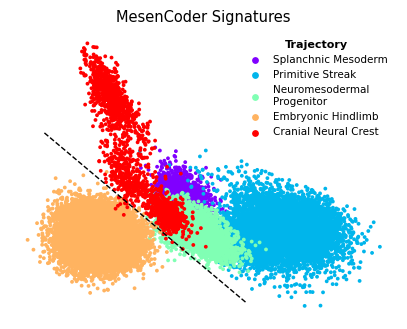

In [6]:
msk_train = (adata.obs.training == 'True')
msk_val = (adata.obs.validation == 'True')
adata_traj = adata[msk_train | msk_val].copy()
adata_traj.obs['source'] = adata_traj.obs.source.map(src_dict)

# plot early/late signatures
fig, ax = plt.subplots(1, 1, figsize = (5, 3.75))
sc.pl.embedding(adata_traj, 'X_mod', color = 'source', size = 30,
                palette = 'rainbow', legend_loc = 'upper right',
                legend_fontsize = 7.5, frameon = False, show = False,
                ax = ax)

xy0, xy1 = .225, .3
ax.plot([-xy0, xy1], [xy0, -xy1], c = 'k', lw = 1, ls = '--')

leg = ax.get_legend()
leg.set_frame_on(False)
for h in leg.legend_handles: h.set_sizes([15])
leg.set_title('Trajectory', {'size' : 8, 'weight' : 'bold'})
ax.set_title('MesenCoder Signatures', size = 10.5)
fn = os.path.join(pth_out, 'signatures.pdf')
plt.savefig(fn, bbox_inches = 'tight')

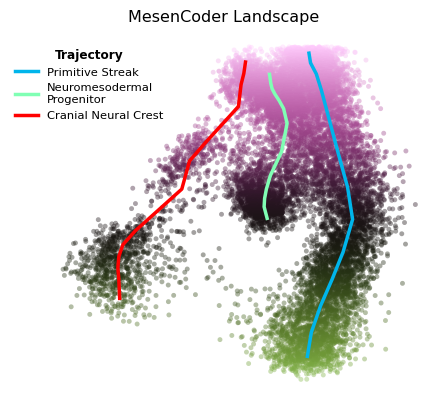

In [7]:
src_plt = ('GSE162534', 'GSE229103', 'rRNAModifications')
msk_src = adata.obs.source.isin(src_plt)
adata_plt = adata[msk_src & (msk_train | msk_val)].copy()
dims = ['X_mesen1', 'X_mesen2']
adata_plt.obs[dims] = adata_plt.obsm['X_mesen'].copy()

# plot signature/latent landscape
fig, ax = plt.subplots(1, 1, figsize = (5, 4.75))
sc.pl.embedding(adata_plt, 'X_mesen', size = 50, alpha = .4,
                color = 'latent_z', vmin = 0, vmax = 1,
                cmap = 'vanimo', colorbar_loc = None,
                frameon = False, show = False, ax = ax)

# draw trajectories
cix = {'GSE162534' : 1, 'GSE229103' : 2, 'rRNAModifications' : 4}
for src, sdf in adata_plt.obs.groupby('source', observed = True):
    sdf = sdf.copy()
    sdf['latent_z_bin'] = pd.qcut(sdf.latent_z, 13)
    sdf = sdf.groupby('latent_z_bin', observed = True)[dims].mean()
    ax.plot(sdf.X_mesen1, sdf.X_mesen2, lw = 2.5, label = src_dict[src],
            color = adata_traj.uns['source_colors'][cix[src]])

ax.invert_yaxis()
leg = ax.legend(bbox_to_anchor = (.33, .725),
                frameon = False, fontsize = 8.25)
leg.set_title('Trajectory', {'size' : 8.75,
                             'weight' : 'bold'})
ax.set_title('MesenCoder Landscape      ', size = 11.5)
fn = os.path.join(pth_out, 'landscape.pdf')
plt.savefig(fn, bbox_inches = 'tight')